# Learn CPTs of Bayesian Netork

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Loading two BNs

In [3]:
bn=gum.loadBN(os.path.join("out","VisitAsia.bif"))
bn2=gum.loadBN(os.path.join("out","VisitAsia.bif"))

gnb.sideBySide(bn,bn2,
               captions=['First bn','Second bn'])

First bn,Second bn


In [4]:
bn.cpt("D")

(gum::Potential<double>@0x7fd2a3eb81a0) 
             ||  D                |
B     |E     ||0        |1        |
------|------||---------|---------|
0     |0     || 0.9000  | 0.1000  |
1     |0     || 0.2000  | 0.8000  |
0     |1     || 0.3000  | 0.7000  |
1     |1     || 0.1000  | 0.9000  |

## Randomizing the parameters

In [5]:
bn.generateCPTs()
bn2.generateCPTs()

## Direct comparison of parameters

In [6]:
from IPython.display import HTML

gnb.sideBySide(bn.cpt(3),
               bn2.cpt(3),
               captions=['<h3>cpt of node 3 in first bn</h3>','<h3>same cpt in second bn</h3>'])


## Exact KL-divergence 

Since the BN is not too big, BruteForceKL can be computed ...

In [7]:
g1=gum.ExactBNdistance(bn,bn2)
before_learning=g1.compute()
print(before_learning['klPQ'])

2.1507546203131174


Just to be sure that the distance between a BN and itself is 0 :

In [8]:
g0=gum.ExactBNdistance(bn,bn)
print(g0.compute()['klPQ'])

0.0


## Generate a database from the original BN

In [9]:
gum.generateCSV(bn,os.path.join("out","test.csv"),10000,False)

-69612.60067622665

## Using pandas for _counting

As an exercise, we will use pandas to learn the parameters. However **<font color="red">the simplest way to learn parameters is to use `BNLearner` :-)</font>**. Moreover, you will be able to add priors, etc.


In [10]:
# using bn as a template for the specification of variables in test.csv
learner=gum.BNLearner(os.path.join("out","test.csv"),bn) 
bn3=learner.learnParameters(bn.dag())

#the same but we add a Laplace adjustment as a Prior
learner=gum.BNLearner(os.path.join("out","test.csv"),bn) 
learner.useAprioriSmoothing(1000) # a count C is replaced by C+1000
bn4=learner.learnParameters(bn.dag())

after_pyAgrum_learning=gum.ExactBNdistance(bn,bn3).compute()
after_pyAgrum_learning_with_laplace=gum.ExactBNdistance(bn,bn4).compute()
print("without priori :{}".format(after_pyAgrum_learning['klPQ']))
print("with prior smooting(1000):{}".format(after_pyAgrum_learning_with_laplace['klPQ']))

without priori :0.002022052419198859
with prior smooting(1000):0.1361356677351893


### Now, let's try to learn the parameters with pandas

In [11]:
import pandas
df=pandas.read_csv(os.path.join("out","test.csv"))
df.head()

,T,A,S,L,X,D,B,E
0,1,0,0,1,1,1,0,0
1,1,0,0,0,1,1,0,1
2,1,0,0,1,1,1,1,1
3,1,0,0,1,1,1,0,1
4,1,1,1,1,0,1,0,0


We use the crosstab function in pandas

In [12]:
c=pandas.crosstab(df['D'],[df['T'],df['B']])
c

T    0          1      
B    0    1     0     1
D                      
0  750  716  1843  2190
1  724  451  2124  1202

Playing with numpy reshaping, we retrieve the good form for the CPT from the pandas cross-table

In [13]:
gnb.sideBySide('<pre>'+str(np.array((c/c.sum().apply(np.float32)).transpose()).reshape(2,2,2))+'</pre>',
               bn.cpt(bn.idFromName('D')),
               captions=["<h3>Learned parameters in crosstab","<h3>Original parameters in bn</h3>"])

## A global method for estimating Bayesian network parameters from CSV file using PANDAS

In [14]:
def computeCPTfromDF(bn,df,name):
    """
    Compute the CPT of variable "name" in the BN bn from the database df
    """
    id=bn.idFromName(name)
    domains=[bn.variableFromName(name).domainSize() 
             for name in bn.cpt(id).var_names]

    parents=list(bn.cpt(id).var_names)
    parents.pop()
    
    if (len(parents)>0):
        c=pandas.crosstab(df[name],[df[parent] for parent in parents])
        s=c/c.sum().apply(np.float32)
    else:
        s=df[name].value_counts(normalize=True)
        
    bn.cpt(id)[:]=np.array((s).transpose()).reshape(*domains)
    
def ParametersLearning(bn,df):
    """
    Compute the CPTs of every varaible in the BN bn from the database df
    """
    for name in bn.names():
        computeCPTfromDF(bn,df,name)

In [15]:
ParametersLearning(bn2,df)

KL has decreased a lot (if everything's OK)

In [16]:
g1=gum.ExactBNdistance(bn,bn2)
print("BEFORE LEARNING")
print(before_learning['klPQ'])
print
print("AFTER LEARNING")
print(g1.compute()['klPQ'])

BEFORE LEARNING
2.1507546203131174
AFTER LEARNING
0.016727399217190093


And CPTs should be close

In [17]:
gnb.sideBySide(bn.cpt(3),
               bn2.cpt(3),
               captions=["<h3>Original BN","<h3>learned BN</h3>"])

## Influence of the size of the database on the quality of learned parameters

What is the effect of increasing the size of the database on the KL ? We expect that the KL decreases to 0.

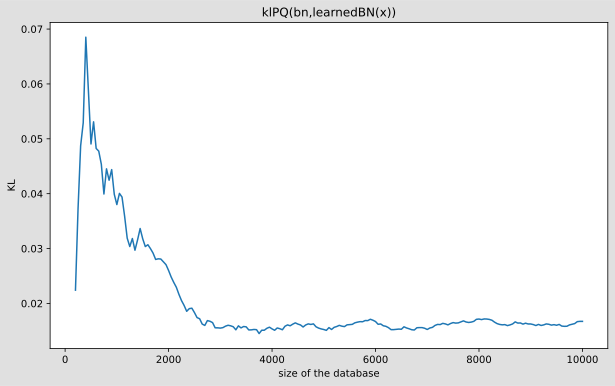

In [18]:
res=[]
for i in range(200,10001,50):
    ParametersLearning(bn2,df[:i])
    g1=gum.ExactBNdistance(bn,bn2)
    res.append(g1.compute()['klPQ'])
fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(range(200,10001,50),res)
ax.set_xlabel("size of the database")
ax.set_ylabel("KL")
t=ax.set_title("klPQ(bn,learnedBN(x))")